In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Common imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader , TensorDataset, WeightedRandomSampler, random_split
from PIL import Image
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Earlystopping code from the internet.

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Custom DataLoader class
 * To tensor and Tried Flipping (disabled in the final version)

In [3]:
class DataSet():
    def __init__(self, root, labels, folder):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """

        self.ROOT = root
        self.images = DataSet._get_data(root, os.listdir(root + "/"+folder), folder)
        self.labels = torch.tensor(labels)

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.images)
    
    @classmethod
    def _get_data(cls,root,img_list, folder):
        data_list = []
        for img_path in img_list:
#             print(os.path.join(root + "/"+folder +"/",img_path))
            im_as_np = Image.open(os.path.join(root + "/"+folder +"/",img_path))
#             flip_im_as_np = tt.transforms.RandomHorizontalFlip()(im_as_np) # Tried Flipping
            data_list.append(tt.transforms.ToTensor()(im_as_np))
#         print(data_list)
            #data_list.append(tt.ToTensor().unsqueeze(0))
        return torch.stack(data_list, dim=0)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
                    The PyTorch DataLoader class will use this method to make an iterable for
                    our training or validation loop.
                """

        img = self.images[idx]
        label = self.labels[idx]

        return img, label

# Extracting the file names

In [4]:
files_no_ext = [".".join(f.split(".")[:-1]) for f in os.listdir('/kaggle/input/deep-learning-for-msc-coursework-2021/train/train')]
files_no_ext = list(map(int, files_no_ext))


# Load the labels

In [5]:
train_data = pd.read_csv("/kaggle/input/deep-learning-for-msc-coursework-2021/train.csv")
train_data.set_index('Id', inplace=True)
train_data = train_data.reindex(files_no_ext)

labels = train_data['Type'].values.tolist()
total_labels = [value.strip(' ') for value in labels]


# Seed set manually

In [6]:
# Set the seed for reproducibility
torch.manual_seed(0)

# Convert into labels from strings

In [7]:
dic = {'Connective':0, 'Immune':1, 'Cancer':2, 'Normal':3}

labels = [dic.get(n, n) for n in total_labels]


In [8]:
ds = DataSet('/kaggle/input/deep-learning-for-msc-coursework-2021/train', labels, "train")

# Validation Set - about 30%

In [9]:
val_size = 538
train_size = len(ds) - val_size
train_ds, val_ds = random_split(ds, [train_size, val_size])

len(train_ds), len(val_ds)

(1652, 538)

* Using weighted **Random sampler**, sample the undersampled ('Normal') class more


In [10]:

def wrsampler(dataset):
    class_weights = []
    counter_dict = dict(Counter(labels))
    print(counter_dict)
    sample_weights = [0] * len(dataset)
    # print(sample_weights)
    for idx, (data,label) in enumerate(dataset):
        class_weight = 1/counter_dict[int(label)]
        sample_weights[idx] = class_weight
    #     print(class_weight)

    sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)
    loader = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle=False, sampler = sampler)

    after_weights = []
    for d,l in loader:
        after_weights.extend(list(l.tolist()))
    print(Counter(after_weights))
    return loader

**Model Definition**
1. With Dropout at Visible and hidden layers
2. Batch Normalization
3. Maxpooling
4. Weight Decay - 0.0001
5. Learning rate - 0.0001

In [11]:
import collections

Nhidden = 25 # experiment with this
lamb=0.0001
lr = 0.0001
epochs = 100
torch.cuda.empty_cache()
net2d = nn.Sequential(collections.OrderedDict([
        ('conv1', nn.Conv2d(3,64,3, padding=1 )), # 16*64*64  64-5+1+4=64
        ('Norm1', nn.BatchNorm2d(64)),
        ('relu1', nn.ReLU()),
        ('pool1', nn.MaxPool2d(2,2)), # 16*32*32
    
        ('conv3', nn.Conv2d(64,128,3, padding=1)), # 64*16*16  
        ('Norm2', nn.BatchNorm2d(128)),
        ('relu3', nn.ReLU()),
        ('Dropout1', nn.Dropout(0.25)),
        ('pool3', nn.MaxPool2d(2,2)),
    
    
        ('conv5', nn.Conv2d(128,512,3, padding=1)), # 128*8*8
        ('Norm3', nn.BatchNorm2d(512)),
        ('relu5', nn.ReLU()),
        ('Dropout2', nn.Dropout(0.25)),
        ('pool5', nn.MaxPool2d(2,2)),

        ('conv6', nn.Conv2d(512,512,3, padding=1)), # 128*8*8
        ('Norm4', nn.BatchNorm2d(512)),
        ('Dropout3', nn.Dropout(0.25)),
        ('relu6', nn.ReLU()),
        ('pool6', nn.MaxPool2d(2,2)),
    
        ('flatten', nn.Flatten()),
        ('layer1', nn.Linear(512*4*4,1024)),
        ('relu7', nn.ReLU()),
        ('Dropout4', nn.Dropout(0.25)),

        ('layer2', nn.Linear(1024,512)),
        ('relu8', nn.ReLU()),
        ('Dropout5', nn.Dropout(0.25)),

    
        ('layer5', nn.Linear(512,4)),  
        ]))


In [12]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
if torch.cuda.is_available():
    modelfi = net2d.cuda()
else:
    modelfi = net2d


In [13]:
device

device(type='cuda')

**Loaders Train and Validation**

In [14]:
loader = wrsampler(train_ds)
val_loader = wrsampler(val_ds)

{3: 189, 0: 726, 1: 729, 2: 546}
Counter({3: 434, 0: 433, 2: 409, 1: 376})
{3: 189, 0: 726, 1: 729, 2: 546}
Counter({1: 168, 0: 133, 2: 126, 3: 111})


# Train and Perform Early stopping with the help of Validation set

In [15]:
import datetime as datetime
epoch_print_gap = 10
optimizer = optim.Adam(modelfi.parameters(), lr=lr, weight_decay=lamb) # Note that this is adding L2 regularisation with factor lamb to every parameter
loss_fn = nn.CrossEntropyLoss()
epoch_dict = {}
prev_loss = 0

# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
avg_train_losses = []
avg_valid_losses = []


early_stopping = EarlyStopping()
for epoch in range(1, epochs + 1):
    loss_train = 0.0
    loss_val = 0.0
    for imgs, tlabels in loader:
        outputs = modelfi(imgs.to(device))
        loss = loss_fn(outputs, tlabels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        train_losses.append(loss.item())
    if epoch ==1:
        prev_loss = loss_train
        
    epoch_dict[epoch] = loss_train
    
    
    if epoch == 1 or epoch % epoch_print_gap == 0:
        print('{} Epoch {}, Training loss {}'.format(
            datetime.datetime.now(), epoch, float(loss_train)))
        
    ######################    
    # validate the model #
    ######################
    modelfi.eval() # prep model for evaluation
    for data, target in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modelfi(data.to(device))
        # calculate the loss
        loss = loss_fn(output, target.to(device))
        # record validation loss
        loss_val += loss.item()
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.5f} ' +
                 f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    #early_stopping needs the validation loss to check if it has decresed, 
    #and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, modelfi)

    if early_stopping.early_stop:
        print("Early stopping")
        break

2021-05-24 09:36:06.904482 Epoch 1, Training loss 94.5222941339016
[  1/100] train_loss: 0.90887 valid_loss: 0.85275
[  2/100] train_loss: 0.66792 valid_loss: 0.63960
[  3/100] train_loss: 0.56580 valid_loss: 0.59671
[  4/100] train_loss: 0.47962 valid_loss: 0.68008
EarlyStopping counter: 1 out of 10
[  5/100] train_loss: 0.39304 valid_loss: 1.24896
EarlyStopping counter: 2 out of 10
[  6/100] train_loss: 0.35584 valid_loss: 0.75679
EarlyStopping counter: 3 out of 10
[  7/100] train_loss: 0.32402 valid_loss: 0.68395
EarlyStopping counter: 4 out of 10
[  8/100] train_loss: 0.22209 valid_loss: 0.93978
EarlyStopping counter: 5 out of 10
[  9/100] train_loss: 0.16737 valid_loss: 0.95685
EarlyStopping counter: 6 out of 10
2021-05-24 09:36:22.516732 Epoch 10, Training loss 17.5916685461998
[ 10/100] train_loss: 0.16915 valid_loss: 0.81921
EarlyStopping counter: 7 out of 10
[ 11/100] train_loss: 0.12087 valid_loss: 1.29122
EarlyStopping counter: 8 out of 10
[ 12/100] train_loss: 0.06736 valid

In [16]:
datetime.datetime.now()

datetime.datetime(2021, 5, 24, 9, 36, 27, 632952)

# Test Loop

In [17]:

def test_loop(model, device, test_loader, loss_fn):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             print("Target", target, pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print(pred, (target.view_as(pred)))
# test on Val
test_loop(modelfi, device, val_loader, loss_fn)



Test set: Average loss: 0.0813, Accuracy: 372/538 (69%)

tensor([[1],
        [1],
        [0],
        [1],
        [2],
        [0],
        [2],
        [2],
        [1],
        [0]], device='cuda:0') tensor([[1],
        [1],
        [2],
        [0],
        [2],
        [2],
        [2],
        [2],
        [0],
        [1]], device='cuda:0')


# Plot Loss against Epochs & Early stopping


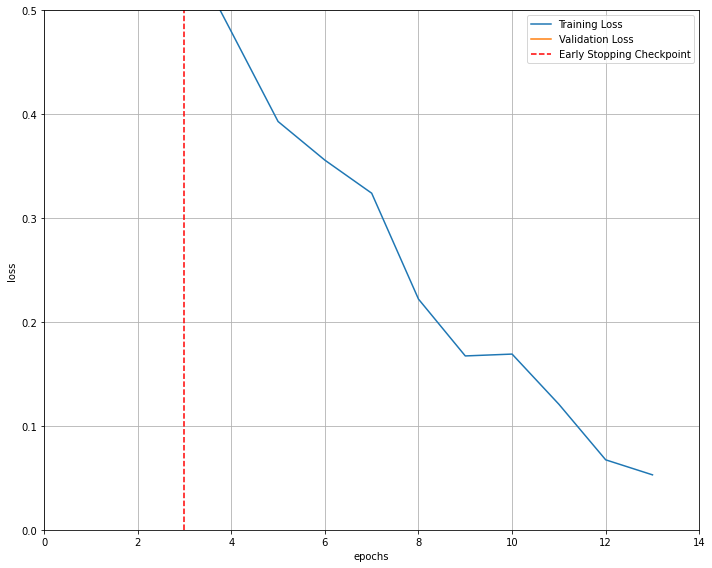

In [18]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# Converting back from labels to strings.

In [19]:
datasett = ImageFolder("../input/deep-learning-for-msc-coursework-2021/test/", transform=tt.Compose([tt.ToTensor()]))
test_loader = torch.utils.data.DataLoader(datasett)
output_final = []
for data, target in test_loader:
    #data, target = data.to(device), target.to(device)
    output = modelfi(data.to(device))
    output_final.extend(list(output.argmax(dim=1, keepdim=True).storage()))
    
print(Counter(output_final))
dic = {0:'Connective', 1:'Immune', 2:'Cancer', 3:'Normal'}

Counter({2: 133, 0: 128, 1: 89, 3: 50})


# Results Predicted:
   # * Cancer: 133 
   # * Connective : 128 
   # * Immune: 89
   # * Normal: 50



# To CSV

In [20]:
real_output = [dic.get(n, n) for n in output_final]
# d = pd.DataFrame(range(10001, 10401), real_output)
d = {'Id': np.arange(10001, 10401), 'Type': real_output}
df = pd.DataFrame(data=d)
df.to_csv("test.csv", index=False)